In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Load prepared data

In [2]:
dir_path = "/Users/chikakoolsen/opt/python/thesis/code/tdcs_thesis/"
# dir_path = "/Users/mriworkshop/Documents/TDCS/code/tdcs_thesis/"
save_path = dir_path+"data/raw/"
img_path =  dir_path+"data/processed/"
model_path = dir_path+"models/"

## fmap mean all experiments

In [3]:
file_mean = save_path+"fmap_mean_erode.txt"
columns_mean =['exp', 'mini_exp', 'i', 'j', 'k', 'mean0', 'mean1', 'mean2', 'mean3', 'mean4', 'theory']
data = np.loadtxt(file_mean);

In [4]:
df = pd.DataFrame(data, columns=columns_mean)
df = df.astype({"exp": int, "i": int, "j": int, "k": int, "mini_exp": int})
df

,exp,mini_exp,i,j,k,mean0,mean1,mean2,mean3,mean4,theory
0,36,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,36,1,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0
3,36,1,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0
4,36,1,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5046267,35,5,43,63,59,0.0,0.0,0.0,0.0,0.0,0.0
5046268,35,5,43,63,60,0.0,0.0,0.0,0.0,0.0,0.0
5046269,35,5,43,63,61,0.0,0.0,0.0,0.0,0.0,0.0
5046270,35,5,43,63,62,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046272 entries, 0 to 5046271
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   exp       int64  
 1   mini_exp  int64  
 2   i         int64  
 3   j         int64  
 4   k         int64  
 5   mean0     float64
 6   mean1     float64
 7   mean2     float64
 8   mean3     float64
 9   mean4     float64
 10  theory    float64
dtypes: float64(6), int64(5)
memory usage: 423.5 MB


# Split data

## Data 1. fmap mean all experiments

In [6]:
df1_train = df[~((df['exp']==36) & ((df['mini_exp']==5) | (df['mini_exp']==6)))]
df1_val =  df[(df['exp']==36) & (df['mini_exp']==5)]
df1_test =  df[(df['exp']==36) & (df['mini_exp']==6)]

In [7]:
print(df1_train.shape)
print(df1_val.shape)
print(df1_test.shape)

(4685824, 11)
(180224, 11)
(180224, 11)


In [8]:
X1_train = df1_train.iloc[:, 5:-1].values 
y1_train = df1_train['theory'].values

X1_test = df1_val.iloc[:, 5:-1].values 
y1_test = df1_val['theory'].values

X1_pred = df1_test.iloc[:, 5:-1].values 
y1_pred = df1_val['theory'].values

In [9]:
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)
print(X1_pred.shape)
print(y1_pred.shape)

(4685824, 5)
(4685824,)
(180224, 5)
(180224,)
(180224, 5)
(180224,)


# Create estimator

In [10]:
X_train = X1_train
y_train = y1_train
X_test = X1_test
y_test = y1_test

In [11]:
shape = (len(X_train[0]),)
def create_model():
    model = keras.Sequential()
    model.add(Dense(7, activation='relu', input_shape=shape)) 
    model.add(Dense(7, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='RMSprop', loss='mse', metrics=["mean_squared_error"])
    return model

In [12]:
estimator = KerasRegressor(model=create_model, verbose=1)

# Visualizing validation curves

In [34]:
param_range = [50, 100, 200, 300, 500]

train_scores, test_scores = validation_curve(
                estimator=estimator, 
                X=X_train, 
                y=y_train, 
                param_name='epoch', 
                param_range=param_range,
                cv=5,
                n_jobs=-1,
                scoring = 'neg_mean_squared_error',
                verbose=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training MSE')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation MSE')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter epoch for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(epoch=50)`
Check the list of available parameters with `estimator.get_params().keys()`

# Visualizing learning curves

[learning_curve] Training set sizes: [ 500000 1000000 2000000 3000000 3700000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
2022-12-11 22:58:10.494299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:58:10.530627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:58:10.611659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions 

 9807/93750 [==>...........................] - ETA: 1:1800 - loss: 8.8501 - mean_squared_error: 8.85

2022-12-11 23:06:07.989576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14927/93750 [===>..........................] - ETA: 1:15s - loss: 8.7312 - mean_squared_error: 8.73

2022-12-11 23:11:09.142463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 7196/15625 [============>.................] - ETA: 10s - loss: 116.9346 - mean_squared_error: 116.9346

2022-12-11 23:11:19.284637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


47495/62500 [=====================>........] - ETA: 17s - loss: 21.8345 - mean_squared_error: 21.8345

2022-12-11 23:13:22.621877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 54567/115625 [=============>................] - ETA: 1:14 - loss: 15.1887 - mean_squared_error: 15.1887

2022-12-11 23:15:54.224213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


88403/93750 [===========================>..] - ETA: 5s

2022-12-11 23:17:28.387110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


115625/115625 [==============================] - 105s 904us/step


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 25.8min finished


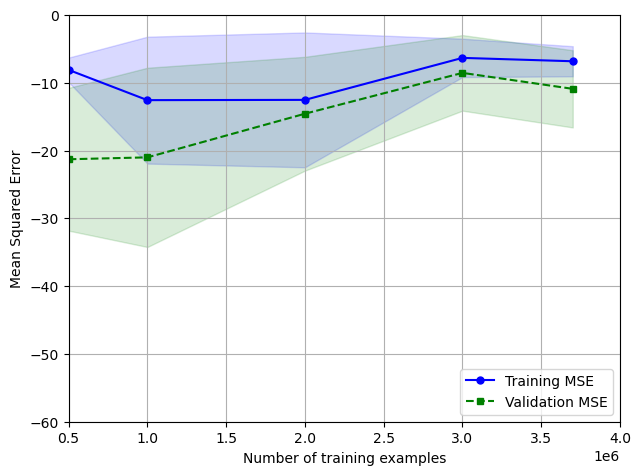

In [24]:
train_sizes = [500000, 1000000, 2000000, 3000000, 3700000]

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=estimator,
                               X=X_train,
                               y=y_train,
                               train_sizes=train_sizes,
                               cv=5,
                               n_jobs=-1,
                               scoring = 'neg_mean_squared_error', 
                               verbose=1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training MSE')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation MSE')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Mean Squared Error')
plt.legend(loc='lower right')
plt.tight_layout()
plt.axis([500000,4000000, -60, 0])
plt.show()


In [21]:
X_train.shape

(4685824, 5)